In [1]:
%load_ext autoreload

In [2]:
%autoreload

import sys
sys.path.append('..')

import os
import re
import csv

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import color.data.colors_big as dataset

In [3]:
# Choose embedding file
datasets_path = os.path.join('..', 'datasets')
emb_dir = os.path.join(datasets_path, 'embeddings')
emb_files = [os.path.join(emb_dir, f) for f in os.listdir(emb_dir)]
emb_dims = 50 # 50, 100, 200, 300
emb_file = list(filter(lambda f: str(emb_dims) in f, emb_files))[0]
emb_file

'../datasets/embeddings/glove.6B.50d.txt'

In [4]:
# Parse embeddings
emb_df = pd.read_csv(emb_file, sep=' ', engine='c', encoding='utf-8',
                     quoting=csv.QUOTE_NONE, header=None,
                     keep_default_na=False, na_values=['%%%&&&???@@@'])
vocab = emb_df[0]
emb_df.drop(0, axis=1, inplace=True)
emb_matrix = emb_df.astype('float').values
emb_dict = {vocab[i]: emb_matrix[i] for i in range(len(vocab))}

emb_matrix.shape

(400000, 50)

In [5]:
# Embedding Characters
emb_words = set(vocab)
emb_chars = set()
for word in emb_words:
    for char in word:
        emb_chars.add(char)
len(emb_words), len(emb_chars)

(400000, 489)

In [6]:
# Extract words from color names
color_words = set()
color_names, color_rgb = dataset.load_color_names()
print('Color map:', color_rgb.shape)
for name in color_names:
    for comps in name.split():
        color_words.add(comps.lower())
len(color_words)

Color map: (18081, 3)


9807

In [7]:
# Color characters from color names
color_chars = set()
for word in color_words:
    for char in word:
        color_chars.add(char)
len(color_chars)

90

In [8]:
# Overlaps
common_words = color_words & emb_words
print('Common Words: {} [{:.2f}%]'.format(len(common_words), len(common_words)*100/len(color_words)))

common_chars = color_chars & emb_chars
print('Common Characters: {} [{:.2f}%]'.format(len(common_chars), len(common_chars)*100/len(color_chars)))

print('Missing Words (50):')
print(list(color_words - emb_words)[:50])

print('Missing Characters:')
print(list(color_chars - emb_chars))


Common Words: 8300 [84.63%]
Common Characters: 88 [97.78%]
Missing Words (50):
['kihada', "carol's", 'urnebes', 'cuit', 'irrigo', 'sonki', 'sinopia', 'lugganath', 'pink-n-purple', "gentleman's", 'ritterlich', 'ghostlands', 'skobeloff', 'agrodolce', 'chrysomela', "apollo's", 'halayà', 'caspia', 'cacodemon', 'ephren', 'stockleaf', 'half-smoke', 'fogtown', 'rickrack', 'rohwurst', 'tambua', 'sunglow', 'sphagnales', 'fiddlesticks', 'garrafa', 'arapawa', 'pīlā', 'kālā', 'tanooki', 'ogon', 'kokushoku', 'nordwand', 'greenshade', 'argeotus', "rock'n'rose", 'brunnera', 'kumera', 'talec', 'stomy', 'sabiseiji', 'sombrio', 'dottyback', 'no$gmb', 'hanyauku', 'fiddle-leaf']
Missing Characters:
['ǎ', 'ǜ']


In [9]:
# Get embeddings for words
# For known words (which have embeddings) just lookup the embedding
# For any other word, generate a random embedding
known_words = ['red', 'black', 'peachy', 'watermelon', 'dog']
unknown_words = ['sussie', 'truesky', "elmer's", 'skavenblight', "bunny's"]
for word in [*known_words, *unknown_words]:
    if word in emb_dict:
        known = True
        emb = np.array(emb_dict[word])
    else:
        known = False
        emb = np.random.rand(emb_dims) - 0.5  # Range (-0.5, 0.5)
    print("Word: {}, Known: {}, Emb Shape: {}\nEmbedding: {}".format(word, known, emb.shape, emb[:5]))

Word: red, Known: True, Emb Shape: (50,)
Embedding: [-0.12878  0.8798  -0.60694  0.12934  0.5868 ]
Word: black, Known: True, Emb Shape: (50,)
Embedding: [-0.96256  0.65329 -0.55152 -0.41065  0.80223]
Word: peachy, Known: True, Emb Shape: (50,)
Embedding: [ 0.0057898  0.71833   -0.60716   -0.6716     0.21509  ]
Word: watermelon, Known: True, Emb Shape: (50,)
Embedding: [-0.11169 -0.73634 -0.87099  0.66481  0.8636 ]
Word: dog, Known: True, Emb Shape: (50,)
Embedding: [ 0.11008 -0.38781 -0.57615 -0.27714  0.70521]
Word: sussie, Known: False, Emb Shape: (50,)
Embedding: [-0.01888662  0.33582921 -0.48494945  0.11186212 -0.444195  ]
Word: truesky, Known: False, Emb Shape: (50,)
Embedding: [-0.37205656  0.41655527 -0.05786557 -0.3768286   0.3959026 ]
Word: elmer's, Known: False, Emb Shape: (50,)
Embedding: [ 0.3129553  -0.17130068  0.23923813 -0.23686071 -0.25638446]
Word: skavenblight, Known: False, Emb Shape: (50,)
Embedding: [-0.20510155  0.13538581  0.16101091  0.01521454  0.06507711]
Wor

In [10]:
# Check similarity b/w words
def similarity(x, y):
    return np.dot(x, y.T) / (np.sqrt(np.dot(x, x.T)) * np.sqrt(np.dot(y, y.T)))

words = [
    ['woman', 'kitchen'],
    ['woman', 'object'],
    ['woman', 'woman'],
]  # Checking bias. No, I am not sexist.
for word1, word2 in words:
    emb1, emb2 = np.array(emb_dict[word1]), np.array(emb_dict[word2])
    print('Similarity b/w "{}" and "{}" is {}'.format(word1, word2, similarity(emb1, emb2)))

Similarity b/w "woman" and "kitchen" is 0.4181231013837278
Similarity b/w "woman" and "object" is 0.4139111260693676
Similarity b/w "woman" and "woman" is 1.0000000000000002


In [11]:
# Get closest words for embeddings

emb_red = np.array(['-0.12878', '0.8798', '-0.60694', '0.12934', '0.5868', '-0.038246', '-1.0408',
 '-0.52881', '-0.29563', '-0.72567', '0.21189', '0.17112', '0.19173', '0.36099',
 '0.032672', '-0.2743', '-0.19291', '-0.10909', '-1.0057', '-0.93901', '-1.0207',
 '-0.69995', '0.57182', '-0.45136', '-1.2145', '-1.1954', '-0.32758', '1.4921',
 '0.54574', '-1.0008', '2.845', '0.26479', '-0.49938', '0.34366', '-0.12574',
 '0.5905', '-0.037696', '-0.47175', '0.050825', '-0.20362', '0.13695', '0.26686',
 '-0.19461', '-0.75482', '1.0303', '-0.057467', '-0.32327', '-0.7712',
 '-0.16764', '-0.73835']).astype(np.float).reshape(50,1)  # Embedding for the word "red"

emb_random = np.random.rand(50) - 0.5  # Candidate for out of vocab words
emb_ones = np.ones_like(emb_red)  # Candidate for stop word

# Choose an embedding to compare
emb_curr = emb_red

# Similary score
embs_mag = np.sqrt(np.sum(emb_matrix*emb_matrix, axis=1)).reshape(-1)  # Norm of all word embeddings
emb_curr_mag = np.sqrt(np.dot(emb_curr.T, emb_curr)).reshape(-1)  # Norm of current word embedding
emb_dot = np.dot(emb_matrix, emb_curr).reshape(-1)  # Dot product of current embedding with all other embeddings
embs_sim = emb_dot / (embs_mag * emb_curr_mag)  # Cosine similary scores

# Most similar word
print('Most similar word:', vocab[np.argmax(embs_sim)], embs_sim[np.argmax(embs_sim)])

# Most dissimilar word
print('Most dissililar word', vocab[np.argmin(embs_sim)], embs_sim[np.argmin(embs_sim)])

Most similar word: red 0.9999999999999999
Most dissililar word esber -0.7445946751683283


In [12]:
# Lets sample out some words embeddings for the purpose of EDA
idx = np.arange(len(emb_dict))
np.random.shuffle(idx)
samp_size = 10000
samp = emb_matrix[idx[:samp_size]]
samp.shape

(10000, 50)

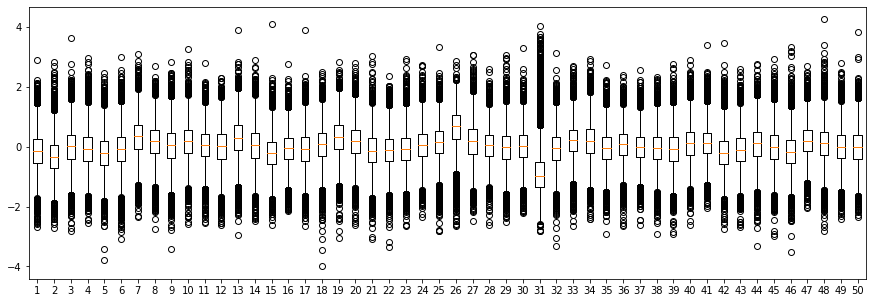

In [13]:
# Embedding Distribution
plt.figure(figsize=(15,5))
plt.boxplot(samp)
plt.show()

In [14]:
# Summary
df = pd.DataFrame(samp)
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,-0.136715,-0.299807,0.004290,-0.055017,-0.191971,-0.082788,0.334686,0.167790,0.043104,0.173428,...,0.139416,-0.174729,-0.089471,0.097420,0.004636,-0.143118,0.201437,0.105027,0.004569,0.006322
std,0.624329,0.613605,0.621776,0.617112,0.634796,0.659180,0.625716,0.598574,0.645433,0.614165,...,0.565951,0.612947,0.603791,0.624464,0.619863,0.614824,0.556535,0.618017,0.595296,0.611967
min,-2.685400,-2.717500,-2.830200,-2.546400,-3.790500,-3.073800,-2.355600,-2.742300,-3.416900,-2.572600,...,-2.036100,-2.764300,-2.671600,-3.314700,-2.983300,-3.513300,-2.064100,-2.806000,-2.425700,-2.360700
25%,-0.536297,-0.703313,-0.397133,-0.464628,-0.598952,-0.481082,-0.069930,-0.199012,-0.364865,-0.213333,...,-0.219017,-0.576215,-0.480843,-0.303242,-0.399095,-0.532658,-0.153450,-0.284793,-0.371247,-0.404655
50%,-0.135230,-0.328570,0.011710,-0.078858,-0.204495,-0.076325,0.351545,0.189305,0.050853,0.199465,...,0.131780,-0.198955,-0.100710,0.115555,0.004114,-0.161190,0.206915,0.111390,0.000633,-0.009116
75%,0.258463,0.070890,0.401483,0.324288,0.203595,0.322085,0.736370,0.574252,0.455680,0.569985,...,0.475745,0.198657,0.298810,0.508087,0.395937,0.223070,0.556218,0.493260,0.384662,0.405772
max,2.918600,2.850200,3.642200,2.972300,2.468700,3.006500,3.096600,2.706200,2.840500,3.269400,...,3.420200,3.470900,2.605500,2.785400,2.928100,3.349800,2.705500,4.265000,2.809600,3.829600


In [15]:
print('IQR:', np.percentile(samp, 25), np.percentile(samp, 75))
print('Mean:', np.mean(samp))

IQR: -0.3869125 0.43646
Mean: 0.022056999884146212
